# Imports

In [289]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
sns.set(rc={'figure.figsize':(25,10)})
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
import holidays

# Transform file to csv

In [8]:
# This is a function definition in Python that takes two arguments: `filename` and `new_filename`, both of which are strings. 
# The function reads the content of an Excel file using the pandas library's `read_excel` function and stores it in a dataframe object. 
# It then writes the contents of the dataframe object to a CSV file using the `to_csv` function,
# with the `index` parameter set to `None` and `header` parameter set to `True`. 
# The function returns `None`. This function can be used to convert an Excel file to a CSV file.

def transform_xls_to_csv(filename: str, new_filename: str) -> None:
    # Read and store content of an excel file 
    read_file = pd.read_excel (filename)
    # Write the dataframe object into csv file
    read_file.to_csv (new_filename, index = None, header=True)

In [78]:
transform_xls_to_csv("../raw_data/bookings_without_onepark.xlsx","../raw_data/bookings_without_onepark.csv")

In [79]:
# This code is defining a dictionary called `custom_dtype` that maps column names to their respective data types.
# The keys of the dictionary are the column names and the values are the data types. 
# The data types include `str` for string, and `float` for floating-point numbers. 
# This dictionary can be used to specify the data types of columns when reading data from a file or database.

custom_dtype = {'id': str,                        
                'pocket':str,
                'product':str,
                'status':str,
                'option':str,
                'guest_id':str,
                'booking_fees':float,
                'amount':float,
                'total_amount':float,
                'discount':float,
                'creation_date_hour':str,
                'beginning_date_hour':str,
                'begining_slice':str,
                'end_date_hour':str,
                'max_date_hour':str,
                'cxl_date_hour':str,
                'los':str,
                'lead_time_hours':float
                }

In [80]:
# This code reads a CSV file named "bookings_without_onepark.csv" located in the "../raw_data/" 
# directory and stores the data in a pandas DataFrame called "df". The "dtype" parameter specifies
# the data types of the columns in the DataFrame, which are defined in a custom dictionary 
# called "custom_dtype". The "parse_dates" parameter specifies which columns should be parsed as datetime objects.
# In this case, the columns "creation_date_hour", "beginning_date_hour", and "end_date_hour" are being parsed as datetime objects.


custom_dtype = {
    'id': int
}

df = pd.read_csv("../raw_data/bookings_without_onepark.csv", 
                 dtype=custom_dtype, 
                 parse_dates=['creation_date_hour', 'beginning_date_hour', 'end_date_hour'])





/var/folders/gn/32bg35111_q711w0ydw7_2rc0000gp/T/ipykernel_23583/1038938611.py:12: DtypeWarning: Columns (1,14,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../raw_data/bookings_without_onepark.csv",


# Cleaning the DF 

In [81]:
# Drop the 'entry_date_hour' and 'exit_date_hour' columns
df = df.drop(['entry_date_hour', 'exit_date_hour','promo_code','amount_promo'], axis=1)

In [82]:
# Check for duplicates based on the 'id' column
duplicates = df.duplicated(subset=['id'])

# Count the number of duplicates
duplicate_count = duplicates.sum()

# Print the number of duplicates
print("Number of duplicates:", duplicate_count)

# Drop the duplicates based on the 'id' column
df = df.drop_duplicates(subset=['id'])

# Print the updated DataFrame without duplicates
print(df.head())

Number of duplicates: 1035
        id  pocket product    status    option    guest_id  booking_fees  \
0  5144307      36     H10  finished  standard  DCL0300508           1.0   
1  5144312     781     H10  finished  standard  DCL0266680           3.0   
2  5144315     491     H10  finished  standard  DCL0286500           3.5   
3  5144319  600287     H10  finished  standard  DCL0254021           4.0   
4  5144320  600287     H10  canceled  standard  DCL0271067           4.0   

   amount  total_amount  discount      creation_date_hour beginning_date_hour  \
0    58.2         59.20      0.00 2019-01-01 09:11:01.000 2019-02-07 15:00:00   
1    29.5         32.50      0.00 2019-01-01 09:32:29.000 2019-01-08 07:30:00   
2    28.8         23.04      9.26 2019-01-01 09:45:16.999 2019-01-02 06:30:00   
3    40.0         44.00      0.00 2019-01-01 09:58:58.999 2019-01-31 05:45:00   
4    56.0         60.00      0.00 2019-01-01 09:59:13.000 2019-01-17 12:30:00   

  begining_slice           en

In [83]:
# Check for nan values and transform them to unknown to count them and to 0 after
df = df.fillna('unknown')
df.isin(['unknown']).sum()
df.replace({'unknown': 0})

,id,pocket,product,status,option,guest_id,booking_fees,amount,total_amount,discount,creation_date_hour,beginning_date_hour,begining_slice,end_date_hour,max_date_hour,cxl_date_hour,los,lead_time_hours
0,5144307,36,H10,finished,standard,DCL0300508,1.0,58.2,59.20,0.00,2019-01-01 09:11:01.000,2019-02-07 15:00:00.000,15H à 18H,2019-02-10 19:44:59.999,0,0,+24h,893.816389
1,5144312,781,H10,finished,standard,DCL0266680,3.0,29.5,32.50,0.00,2019-01-01 09:32:29.000,2019-01-08 07:30:00.000,6H à 9H,2019-01-10 21:30:00.000,0,0,+24h,165.958611
2,5144315,491,H10,finished,standard,DCL0286500,3.5,28.8,23.04,9.26,2019-01-01 09:45:16.999,2019-01-02 06:30:00.000,6H à 9H,2019-01-04 21:45:00.000,0,0,+24h,20.745278
3,5144319,600287,H10,finished,standard,DCL0254021,4.0,40.0,44.00,0.00,2019-01-01 09:58:58.999,2019-01-31 05:45:00.000,0H à 6H,2019-02-02 17:45:00.000,0,0,+24h,715.766944
4,5144320,600287,H10,canceled,standard,DCL0271067,4.0,56.0,60.00,0.00,2019-01-01 09:59:13.000,2019-01-17 12:30:00.000,12H à 15H,2019-01-20 15:59:59.999,0,2019-01-11 18:26:00.000,+24h,386.513056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536169,10276847,0000500287,F397,completed,standard,DCL0129618,0.0,46.5,46.50,0.00,2023-06-18 23:17:23.999,2023-06-23 07:44:59.999,6H à 9H,2023-06-26 17:15:00.000,2023-06-27 07:44:59.999,0,+24h,104.460000
536170,10276859,0000000781,F398,completed,standard,DCL0779147,0.0,46.0,46.00,0.00,2023-06-18 23:22:06.000,2023-07-04 05:29:59.999,0H à 6H,2023-07-10 05:29:59.999,2023-07-11 05:29:59.999,0,+24h,366.131667
536171,10276871,0000000206,F397,completed,standard,DCL0524194,0.0,29.9,29.90,0.00,2023-06-18 23:30:14.000,2023-06-23 15:59:59.999,15H à 18H,2023-06-25 23:29:59.999,2023-06-26 11:59:00.000,0,+24h,112.496111
536172,10276885,0000000206,H10,completed,standard,DCL0311148,0.0,56.9,56.90,0.00,2023-06-18 23:36:58.000,2023-06-19 14:45:00.000,12H à 15H,2023-06-21 22:44:59.999,2023-06-22 02:45:00.000,0,+24h,15.133889


In [84]:
# Count the occurrences of each product and store it in a new DataFrame
product_counts = df['product'].value_counts().reset_index()

# Rename the columns in the new DataFrame
product_counts.columns = ['product', 'count']

# Print the product names and their corresponding counts
print(product_counts)

   product   count
0      H10  313283
1     F397   73963
2     F398   50106
3      F44   40798
4      F98   35490
5      F60    5078
6      F63    4946
7     F109    2996
8     F132    1574
9     F139    1117
10    F400     999
11    F414     995
12    F150     680
13     F54     632
14     F67     495
15    F343     451
16    F138     421
17      F7     378
18     F33     232
19    F319     229
20     F70     106
21    F100      77
22    F110      33
23    F227      20
24    F137      20
25     F58      18
26      F5       1
27    F215       1


In [334]:
# Count the occurrences of each pocket and store it in a new DataFrame
pocket_counts = df['pocket'].value_counts().reset_index()

# Rename the columns in the new DataFrame
pocket_counts.columns = ['pocket', 'count']

# Print the product names and their corresponding counts
print(pocket_counts.head(10))

       pocket  count
0  0000000781  81621
1  0000200287  60483
2  0000100435  32624
3  0000000206  27553
4  0000000272  21492
5  0000000036  19948
6  0000500435  18971
7  0000000034  18080
8  0000000052  15502
9  0000000025  15153


In [88]:
# Replace the names of the products
df['product'] = df['product'].replace({'H10': 'hourly rate', 
                                       'F397':'WE package',
                                       'F398': '1 week package',
                                       'F44': '1 week package',
                                       'F98':'WE package',
                                       'F60': '1 month package',
                                       'F63' : '2 weeks package',
                                       'F109': 'other package',
                                       'F132': 'other package',
                                       'F139': '1 month package',
                                       'F400':'1 month package',
                                       'F414': '2 weeks package',
                                       'F150': 'other package',
                                       'F54': '1 week package',
                                       'F67': 'other package',
                                       'F343': 'WE package',
                                       'F138': '1 week package',
                                       'F7': 'other package',
                                       'F33': '2 weeks package',
                                       'F319':'1 week package',
                                       'F70': '1 month package',
                                       'F100': 'other package',
                                       'F110': 'other package',
                                       'F227': 'other package',
                                       'F137': 'other package',
                                       'F58': 'other package',
                                       'F5' : '1 month package',
                                       'F215': 'other package'
                                       })

# Print the updated DataFrame
print(df)

              id      pocket         product     status    option    guest_id  \
0        5144307          36     hourly rate   finished  standard  DCL0300508   
1        5144312         781     hourly rate   finished  standard  DCL0266680   
2        5144315         491     hourly rate   finished  standard  DCL0286500   
3        5144319      600287     hourly rate   finished  standard  DCL0254021   
4        5144320      600287     hourly rate   canceled  standard  DCL0271067   
...          ...         ...             ...        ...       ...         ...   
536169  10276847  0000500287      WE package  completed  standard  DCL0129618   
536170  10276859  0000000781  1 week package  completed  standard  DCL0779147   
536171  10276871  0000000206      WE package  completed  standard  DCL0524194   
536172  10276885  0000000206     hourly rate  completed  standard  DCL0311148   
536173  10276914  0000000036   other package  completed  standard  DCL0669147   

        booking_fees  amoun

In [89]:
# Count the occurrences of each product and store it in a new DataFrame
product_counts = df['product'].value_counts().reset_index()

# Rename the columns in the new DataFrame
product_counts.columns = ['product', 'count']

# Print the product names and their corresponding counts
print(product_counts)

           product   count
0      hourly rate  313283
1       WE package  109904
2   1 week package   92186
3  1 month package    7301
4    other package    6292
5  2 weeks package    6173


# Creation of df_days, with the nb of bookings, cars and cancellations per days

In [227]:
# Creation of a DataFrame with 1 car for each day, cancellations (cxl), 
# and nb of bookings and cancellations by days of arrival
df_days = pd.DataFrame({
    'date': pd.date_range(start='2021-06-01', end='2023-06-20'),
    'nb_cars': 0,
    'nb_cars_cxl': 0,
    'nb_bookings': 0,
    'nb_bookings_cxl': 0
})

# Print the updated DataFrame
print(df_days.head())


        date  nb_cars  nb_cars_cxl  nb_bookings  nb_bookings_cxl
0 2021-06-01        0            0            0                0
1 2021-06-02        0            0            0                0
2 2021-06-03        0            0            0                0
3 2021-06-04        0            0            0                0
4 2021-06-05        0            0            0                0


In [228]:
# Iterate through each row of the DataFrame `df`
for _, row in df.iterrows():
    start = row['beginning_date_hour']
    end = row['end_date_hour']
    status = row['status']
    
    # Update nb_cars column
    df_days.loc[(df_days['date'] >= start) & (df_days['date'] <= end) & (status != 'canceled'), 'nb_cars'] += 1
    
    # Update nb_cars_canceled column
    df_days.loc[(df_days['date'] >= start) & (df_days['date'] <= end) & (status == 'canceled'), 'nb_cars_cxl'] += 1



In [230]:
# Count the number of bookings and cancellations for each date
booking_counts = df.loc[df['status'] != 'canceled', 'beginning_date_hour'].dt.date.value_counts()
cancellation_counts = df.loc[df['status'] == 'canceled', 'beginning_date_hour'].dt.date.value_counts()

# Update nb_bookings column
df_days['nb_bookings'] = df_days['date'].map(booking_counts).fillna(0).astype(int)

# Update nb_bookings_cxl column
df_days['nb_bookings_cxl'] = df_days['date'].map(cancellation_counts).fillna(0).astype(int)


In [231]:
df_days.head()

,date,nb_cars,nb_cars_cxl,nb_bookings,nb_bookings_cxl
0,2021-06-01,368,30,172,12
1,2021-06-02,395,34,169,4
2,2021-06-03,428,26,170,13
3,2021-06-04,412,25,424,30
4,2021-06-05,695,49,187,16


In [71]:
# Save the df to csv 
df_days.to_csv("../prepared_data/01_06_2021_to_20_06_2023_anais.csv", index=False)

In [134]:
# Convert 'date' column to datetime data type
df_days['date'] = pd.to_datetime(df_days['date'])

# Reshape the DataFrame using melt
df_melted = df_days.melt(id_vars='date', value_vars=['nb_cars', 'nb_cars_cxl', 'nb_bookings', 'nb_bookings_cxl'])

# Create the line plot
fig = go.Figure()

# Add traces for each variable
for variable in ['nb_cars', 'nb_cars_cxl', 'nb_bookings', 'nb_bookings_cxl']:
    fig.add_trace(go.Scatter(
        x=df_melted['date'],
        y=df_melted[df_melted['variable'] == variable]['value'],
        name=variable
    ))

# Add range slider and selectors
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True)
    ),
    title="Number of cars and bookings per day"
)

# Set the height of the plot
fig.update_layout(height=800)

# Show the graph
fig.show()


# Prophet nb of cars

## Just the nb of cars as y

In [281]:
df_prophet_cars = df_days.drop(['nb_cars_cxl', 'nb_bookings', 'nb_bookings_cxl'], axis=1)
df_prophet_cars = df_prophet_cars.rename(columns={'date': 'ds', 'nb_cars': 'y'})
df_prophet_cars.head()

,ds,y
0,2021-06-01,368
1,2021-06-02,395
2,2021-06-03,428
3,2021-06-04,412
4,2021-06-05,695


In [282]:
# Define the split percentages
train_percentage = 0.7
test_percentage = 0.15
validation_percentage = 0.15

# Calculate the number of rows for each set
total_rows = len(df_prophet_cars)
train_rows = int(total_rows * train_percentage)
test_rows = int(total_rows * test_percentage)
validation_rows = total_rows - train_rows - test_rows

# Split the data into train, test, and validation sets
train_set = df_prophet_cars[:train_rows]
test_set = df_prophet_cars[train_rows:train_rows + test_rows]
validation_set = df_prophet_cars[train_rows + test_rows:]

print("train_rows:", train_rows)
print("test_rows:", test_rows)
print("validation_rows:", validation_rows)
print()

train_rows: 525
test_rows: 112
validation_rows: 113



In [292]:
# Create future dates for the test and validation periods
future_test = model.make_future_dataframe(periods=len(test_set))
future_validation = model.make_future_dataframe(periods=len(validation_set))

# Predict on the test and validation sets
forecast_test = model.predict(future_test)
forecast_validation = model.predict(future_validation)


In [293]:
# Calculate RMSE for the test set
y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
print("RMSE for the test set:", rmse_test)

RMSE for the test set: 397.9597032352779


In [294]:
mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)

MAPE for the test set: 26.8794893003168


## Forecast nb of cars with french holidays (from holidays package)

In [310]:
df_prophet_cars = df_days.drop(['nb_cars_cxl', 'nb_bookings', 'nb_bookings_cxl'], axis=1)
df_prophet_cars = df_prophet_cars.rename(columns={'date': 'ds', 'nb_cars': 'y'})

# Add the 'holiday' column
fr_holidays = holidays.France()
df_prophet_cars['holiday'] = df_prophet_cars['ds'].apply(lambda x: x in fr_holidays)
df_prophet_cars['ds'] = pd.to_datetime(df_prophet_cars['ds'])

# Create a separate DataFrame for holidays
holidays_df = df_prophet_cars[df_prophet_cars['holiday']]
holidays_df['holiday'] = 'Holiday'

model = Prophet(holidays=holidays_df)
model.fit(df_prophet_cars)

# Create future dates (365 days)
future = model.make_future_dataframe(periods=365)
future.tail()

# Predict
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Calculate train, test, validation sets and evaluate accuracy
train_percentage = 0.7
test_percentage = 0.15
validation_percentage = 0.15

total_rows = len(df_prophet_cars)
train_rows = int(total_rows * train_percentage)
test_rows = int(total_rows * test_percentage)
validation_rows = total_rows - train_rows - test_rows

train_set = df_prophet_cars[:train_rows]
test_set = df_prophet_cars[train_rows:train_rows + test_rows]
validation_set = df_prophet_cars[train_rows + test_rows:]

model = Prophet(holidays=holidays_df)
model.fit(train_set)

future_test = model.make_future_dataframe(periods=len(test_set))
future_validation = model.make_future_dataframe(periods=len(validation_set))

forecast_test = model.predict(future_test)
forecast_validation = model.predict(future_validation)

y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))





/var/folders/gn/32bg35111_q711w0ydw7_2rc0000gp/T/ipykernel_23583/357578412.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/anaisetienne/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/forecaster.py:175: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

19:59:08 - cmdstanpy - INFO - Chain [1] start processing
19:59:08 - cmdstanpy - INFO - Chain [1] done processing
/Users/anaisetienne/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/forecaster.py:175: S

In [311]:
print("RMSE for the test set:", rmse_test)

mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)

RMSE for the test set: 390.9786677287797
MAPE for the test set: 26.285842603594716


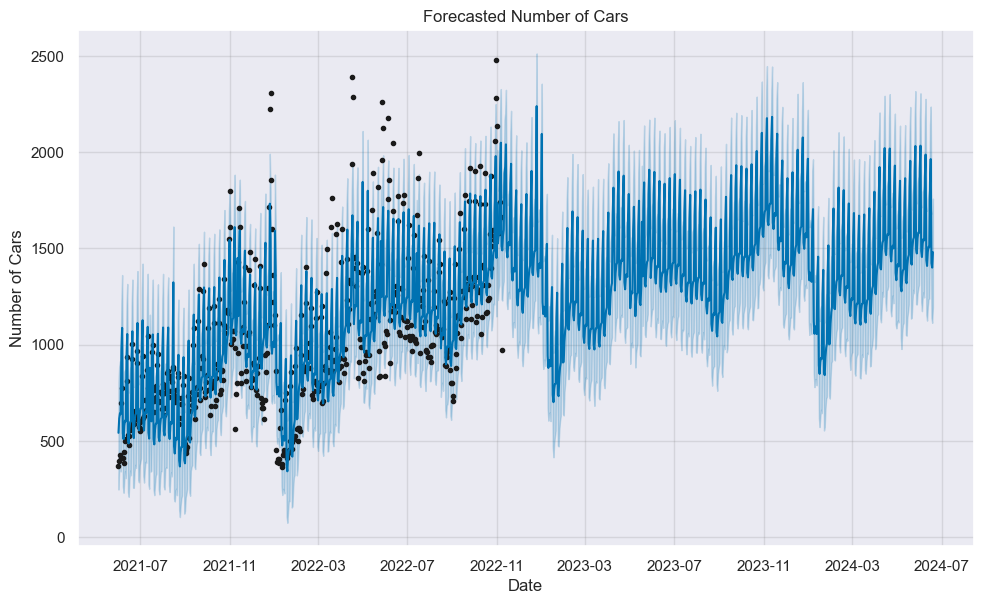

In [305]:
# Plot the graph
fig1 = model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Number of Cars')
plt.title('Forecasted Number of Cars')

plt.show()

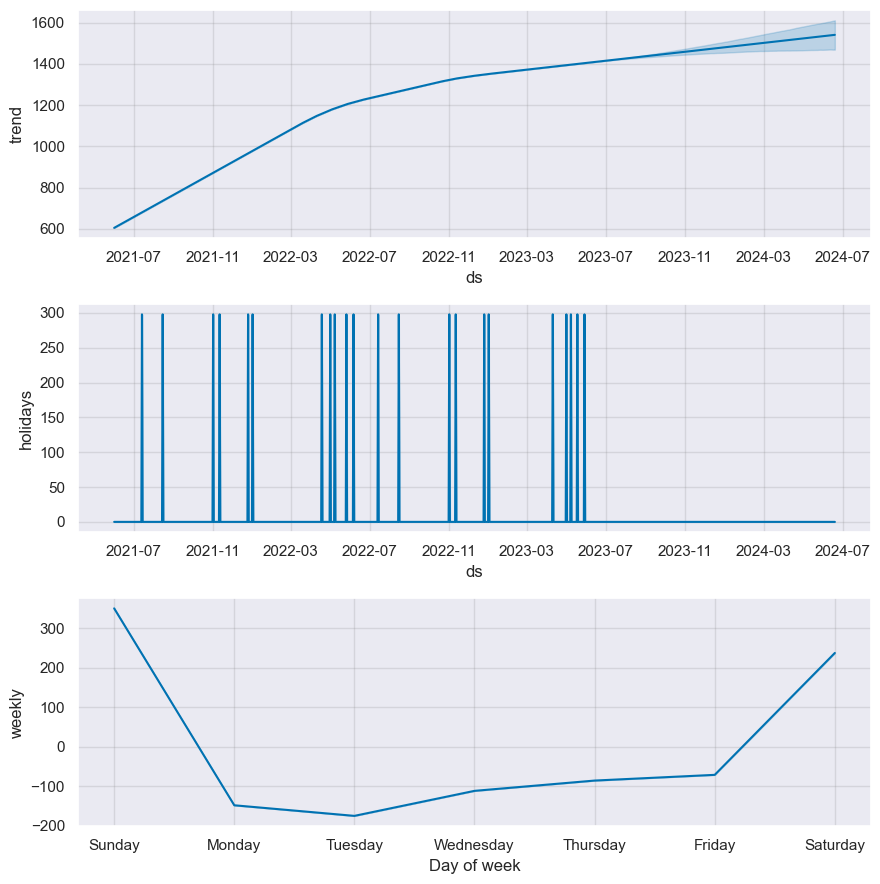

In [306]:
# Explain seasonality
fig2 = model.plot_components(forecast)


# Prophet nb of bookings

## Forecast nb of bookings 

In [327]:
df_prophet_bookings = df_days.drop(['nb_cars_cxl', 'nb_cars', 'nb_bookings_cxl'], axis=1)
df_prophet_bookings = df_prophet_bookings.rename(columns={'date': 'ds', 'nb_bookings': 'y'})
df_prophet_bookings.head()

,ds,y
0,2021-06-01,172
1,2021-06-02,169
2,2021-06-03,170
3,2021-06-04,424
4,2021-06-05,187


In [328]:
# Define the split percentages
train_percentage = 0.7
test_percentage = 0.15
validation_percentage = 0.15

# Calculate the number of rows for each set
total_rows = len(df_prophet_cars)
train_rows = int(total_rows * train_percentage)
test_rows = int(total_rows * test_percentage)
validation_rows = total_rows - train_rows - test_rows

# Split the data into train, test, and validation sets
train_set = df_prophet_bookings[:train_rows]
test_set = df_prophet_bookings[train_rows:train_rows + test_rows]
validation_set = df_prophet_bookings[train_rows + test_rows:]

print("train_rows:", train_rows)
print("test_rows:", test_rows)
print("validation_rows:", validation_rows)
print()

train_rows: 525
test_rows: 112
validation_rows: 113



In [329]:
model2 = Prophet()
model2.fit(train_set)

20:13:58 - cmdstanpy - INFO - Chain [1] start processing


20:13:58 - cmdstanpy - INFO - Chain [1] done processing


In [330]:
# Create future dates for the test and validation periods
future_test = model2.make_future_dataframe(periods=len(test_set))
future_validation = model2.make_future_dataframe(periods=len(validation_set))

# Predict on the test and validation sets
forecast_test = model2.predict(future_test)
forecast_validation = model2.predict(future_validation)

In [331]:
# Calculate RMSE for the test set
y_true_test2 = test_set['y']
y_pred_test2 = forecast_test['yhat'].tail(len(test_set))
rmse_test2 = np.sqrt(mean_squared_error(y_true_test2, y_pred_test2))
print("RMSE for the test set:", rmse_test2)

RMSE for the test set: 181.39963148125503


In [332]:
mape_test2 = mean_absolute_percentage_error(y_true_test2, y_pred_test2) * 100
print("MAPE for the test set:", mape_test2)

MAPE for the test set: 39.737812505237194


## Forecast nb of bookings with holidays (from holidays package)

In [323]:
df_prophet_bookings = df_days.drop(['nb_cars_cxl', 'nb_cars', 'nb_bookings_cxl'], axis=1)
df_prophet_bookings = df_prophet_bookings.rename(columns={'date': 'ds', 'nb_bookings': 'y'})

# Add the 'holiday' column
fr_holidays = holidays.France()
df_prophet_bookings['holiday'] = df_prophet_bookings['ds'].apply(lambda x: x in fr_holidays)
df_prophet_bookings['ds'] = pd.to_datetime(df_prophet_bookings['ds'])

# Create a separate DataFrame for holidays
holidays_df = df_prophet_bookings[df_prophet_bookings['holiday'] == True]
holidays_df['holiday'] = 'Holiday'

model = Prophet(holidays=holidays_df)
model.fit(df_prophet_bookings)

# Create future dates (365 days)
future = model.make_future_dataframe(periods=365)
future.tail()

# Predict
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Calculate train, test, validation sets and evaluate accuracy
train_percentage = 0.7
test_percentage = 0.15
validation_percentage = 0.15

total_rows = len(df_prophet_bookings)
train_rows = int(total_rows * train_percentage)
test_rows = int(total_rows * test_percentage)
validation_rows = total_rows - train_rows - test_rows

train_set = df_prophet_bookings[:train_rows]
test_set = df_prophet_bookings[train_rows:train_rows + test_rows]
validation_set = df_prophet_bookings[train_rows + test_rows:]

model = Prophet(holidays=holidays_df)
model.fit(train_set)

future_test = model.make_future_dataframe(periods=len(test_set))
future_validation = model.make_future_dataframe(periods=len(validation_set))

forecast_test = model.predict(future_test)
forecast_validation = model.predict(future_validation)

y_true_test = test_set['y']
y_pred_test = forecast_test['yhat'].tail(len(test_set))
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))


/var/folders/gn/32bg35111_q711w0ydw7_2rc0000gp/T/ipykernel_23583/3050164235.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/anaisetienne/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/forecaster.py:175: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

20:11:45 - cmdstanpy - INFO - Chain [1] start processing
20:11:45 - cmdstanpy - INFO - Chain [1] done processing
/Users/anaisetienne/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/forecaster.py:175: 

In [324]:
print(df_prophet_bookings.head())

print("RMSE for the test set:", rmse_test)

mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
print("MAPE for the test set:", mape_test)

          ds    y  holiday
0 2021-06-01  172    False
1 2021-06-02  169    False
2 2021-06-03  170    False
3 2021-06-04  424    False
4 2021-06-05  187    False
RMSE for the test set: 181.42208307091207
MAPE for the test set: 39.100669707134


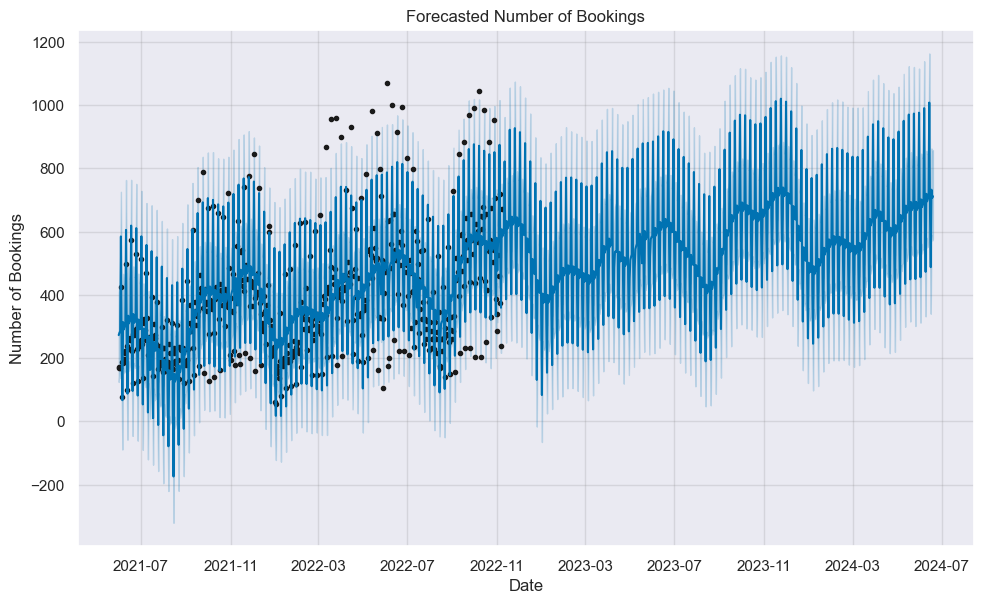

In [325]:
# Plot the graph
fig1 = model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Number of Bookings')
plt.title('Forecasted Number of Bookings')

plt.show()

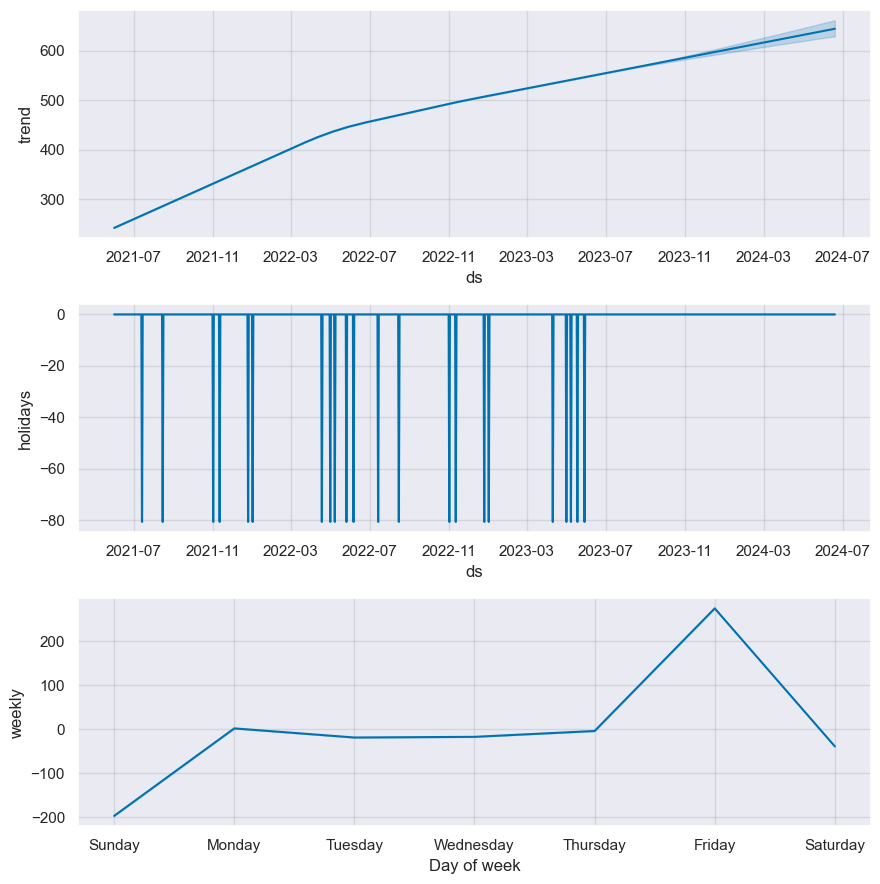

In [326]:
# Explain seasonality
fig2 = model.plot_components(forecast)

# Creation of df_products with the nb of cars per days by products (w/o cancellations)

In [ ]:
# Initialize the DataFrame with required columns
df_turnover = pd.DataFrame({
    'date': pd.date_range(start='2021-06-01', end='2023-06-20'),
    'turnover': 0,
    'discount': 0,
    'booking_fees': 0
})

# Calculate turnover and discount
turnover_data = df.loc[df['status'] != 'canceled'].groupby('date').agg({'amount': 'sum', 'discount': 'sum'}).reset_index()

# Calculate booking fees by arrival date
booking_fees_data = df.loc[df['status'] != 'canceled'].groupby('date').agg({'booking_fees': 'sum'}).reset_index()

# Merge the data into the df_turnover DataFrame
df_turnover = df_turnover.merge(turnover_data, left_on='date', right_on='date', how='left')
df_turnover = df_turnover.merge(booking_fees_data, left_on='date', right_on='date', how='left')
df_turnover = df_turnover.drop(['date'], axis=1)
df_turnover = df_turnover.fillna(0)

# Print the updated DataFrame
print(df_turnover.head())



KeyError: 'date'

In [115]:
# Creation of a DataFrame with 1 car for each day without cancellations, displayed by products 

df_products = pd.DataFrame({
    'date': pd.date_range(start='2021-06-01', end='2023-06-20'),
    'hourly rate': 0,
    'WE package': 0,
    '1 week package': 0,
    '1 month package':0,
    'other package': 0,
    '2 weeks package': 0,   
})

# Print the updated DataFrame
print(df_products.head())

        date  hourly rate  WE package  1 week package  1 month package  \
0 2021-06-01            0           0               0                0   
1 2021-06-02            0           0               0                0   
2 2021-06-03            0           0               0                0   
3 2021-06-04            0           0               0                0   
4 2021-06-05            0           0               0                0   

   other package  2 weeks package  
0              0                0  
1              0                0  
2              0                0  
3              0                0  
4              0                0  


In [117]:
# Iterate through each row of the DataFrame `df`
for _, row in df.iterrows():
    start = row['beginning_date_hour']
    end = row['end_date_hour']
    status = row['status']
    product = row['product']  # Retrieve the product value from the row
    
    # Update the count for the respective product
    df_products.loc[(df_products['date'] >= start) & (df_products['date'] <= end) & (status != 'canceled'), product] += 1


In [118]:
df_products.head()

,date,hourly rate,WE package,1 week package,1 month package,other package,2 weeks package
0,2021-06-01,115,14,176,53,5,5
1,2021-06-02,160,1,171,55,3,5
2,2021-06-03,178,0,189,52,4,5
3,2021-06-04,150,0,205,48,3,6
4,2021-06-05,204,236,199,45,3,8


In [ ]:
# Save the df to csv 
df_products.to_csv("../prepared_data/01_06_2021_to_20_06_2023_products_anais.csv", index=False)

In [137]:
# Plot a graph of the number of cars per day and products
wide_df = pd.DataFrame(df_products)

fig = px.bar(wide_df, 
             x="date", 
             y=["hourly rate", "WE package", "1 week package", "1 month package", "other package", "2 weeks package"], 
             title="Number of cars per day & product")

# Add a range slider and selectors
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

# Set the height of the plot
fig.update_layout(height=800)

# Show the graph
fig.show()


# Creation of df_turnover

In [223]:
# Initialize the DataFrame with the date column
df_turnover = pd.DataFrame({
    'date': pd.date_range(start='2021-06-01', end='2023-06-20')
})

# Calculate turnover by date
df['date'] = pd.to_datetime(df['beginning_date_hour']).dt.date  # Convert 'beginning_date_hour' to date
turnover_data = df.loc[df['status'] != 'canceled'].groupby('date').agg({'amount': 'sum'}).reset_index()
turnover_data = turnover_data.rename(columns={'amount': 'turnover'})
turnover_data['date'] = pd.to_datetime(turnover_data['date'])  # Convert 'date' to datetime

# Calculate discount by date
discount_data = df.loc[df['status'] != 'canceled'].groupby('date').agg({'discount': 'sum'}).reset_index()
discount_data['date'] = pd.to_datetime(discount_data['date'])  # Convert 'date' to datetime

# Calculate booking fees by date
booking_fees_data = df.loc[df['status'] != 'canceled'].groupby('date').agg({'booking_fees': 'sum'}).reset_index()
booking_fees_data['date'] = pd.to_datetime(booking_fees_data['date'])  # Convert 'date' to datetime

# Merge the data into the df_turnover DataFrame
df_turnover = df_turnover.merge(turnover_data, on='date', how='left')
df_turnover = df_turnover.merge(discount_data, on='date', how='left')
df_turnover = df_turnover.merge(booking_fees_data, on='date', how='left')

# Fill NaN values with 0
df_turnover[['turnover', 'discount', 'booking_fees']] = df_turnover[['turnover', 'discount', 'booking_fees']].fillna(0)

# Print the updated DataFrame
print(df_turnover.head())


        date  turnover  discount  booking_fees
0 2021-06-01    6672.1    171.00          25.1
1 2021-06-02    5601.9    140.04          36.1
2 2021-06-03    6409.8    207.81          51.3
3 2021-06-04   14215.1   1048.70         139.9
4 2021-06-05    5812.1    355.23          53.0


In [224]:
# Save the df to csv 
df_products.to_csv("../prepared_data/01_06_2021_to_20_06_2023_turnover_anais.csv", index=False)

In [225]:
# Multiply the discount column by -1 to make it negative
df_turnover['discount'] = df_turnover['discount'] * -1

# Reshape the DataFrame using melt
df_melted = df_turnover.melt(id_vars='date', var_name='category', value_name='amount')

# Create the bar chart
fig = px.bar(df_melted, x='date', y='amount', color='category', barmode='relative',
             labels={'amount': 'Amount', 'category': 'Category'})

# Set the y-axis range to include negative values
fig.update_layout(yaxis_range=[df_melted['amount'].min(), df_melted['amount'].max()])

# Customize the layout
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Amount',
    legend_title='Category',
    barmode='relative',
    bargap=0.2,
    bargroupgap=0.1
)

# Add range slider and selectors
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True)
    ),
    title="Turnover by days (amount of booking, booking fees, and discount)"
)

# Set the height of the plot
fig.update_layout(height=800)

# Show the graph
fig.show()


# Not used for the moment

In [22]:
## NOT NEEDED RIGHT NOW ##

# Compute Z scores 
df['z_score_booking_fees'] = zscore(df['booking_fees'])
df['z_score_amount'] = zscore(df['amount'])
df['z_score_total_amount'] = zscore(df['total_amount'])
df['z_score_discount'] = zscore(df['discount'])

# Find outliers
outliers = df[abs(df['z_score_booking_fees']) > 3]

print(outliers)
print(len(outliers))

              id      pocket product     status   option    guest_id  \
32564    5497261  0000100435     H10   finished  premium  DCL0051721   
32741    5498845  0000100435     H10   finished  premium  DCL0382375   
33060    5501611  0000100435     H10   finished  premium  DCL0382118   
33066    5501688  0000100435     H10   finished  premium  DCL0382764   
33436    5505401  0000100435     H10   finished  premium  DCL0313253   
...          ...         ...     ...        ...      ...         ...   
535771  10273459  0000000025    F398  completed  premium  DCL0880274   
535811  10273802  0000000025     H10  completed  premium  DCL0682660   
536018  10275752  0000100435    F398  completed  premium  DCL0097916   
536043  10275903  0000100435    F398  completed  premium  DCL0248992   
536081  10276221  0000000025     H10  completed  premium  DCL0887448   

        booking_fees  amount  total_amount  discount  ...          los  \
32564            9.0    14.9          23.9       0.0  ...  06

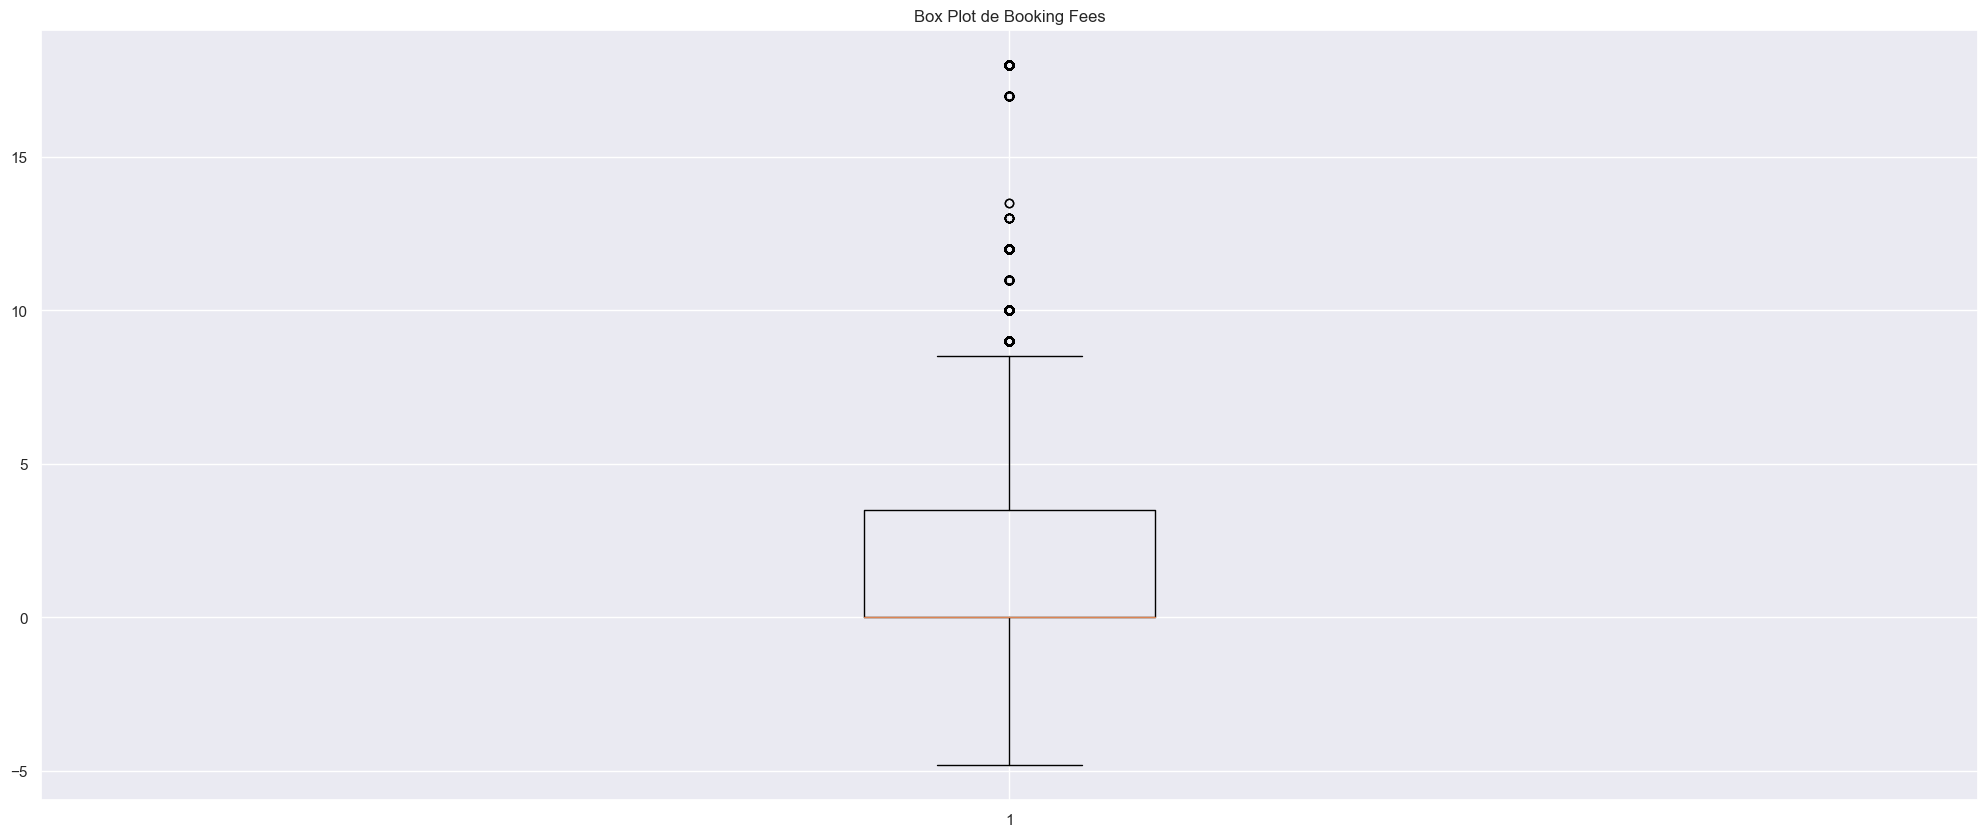

In [21]:
plt.figure()
plt.boxplot(df['booking_fees'].dropna())
plt.title('Box Plot de Booking Fees')
plt.show()

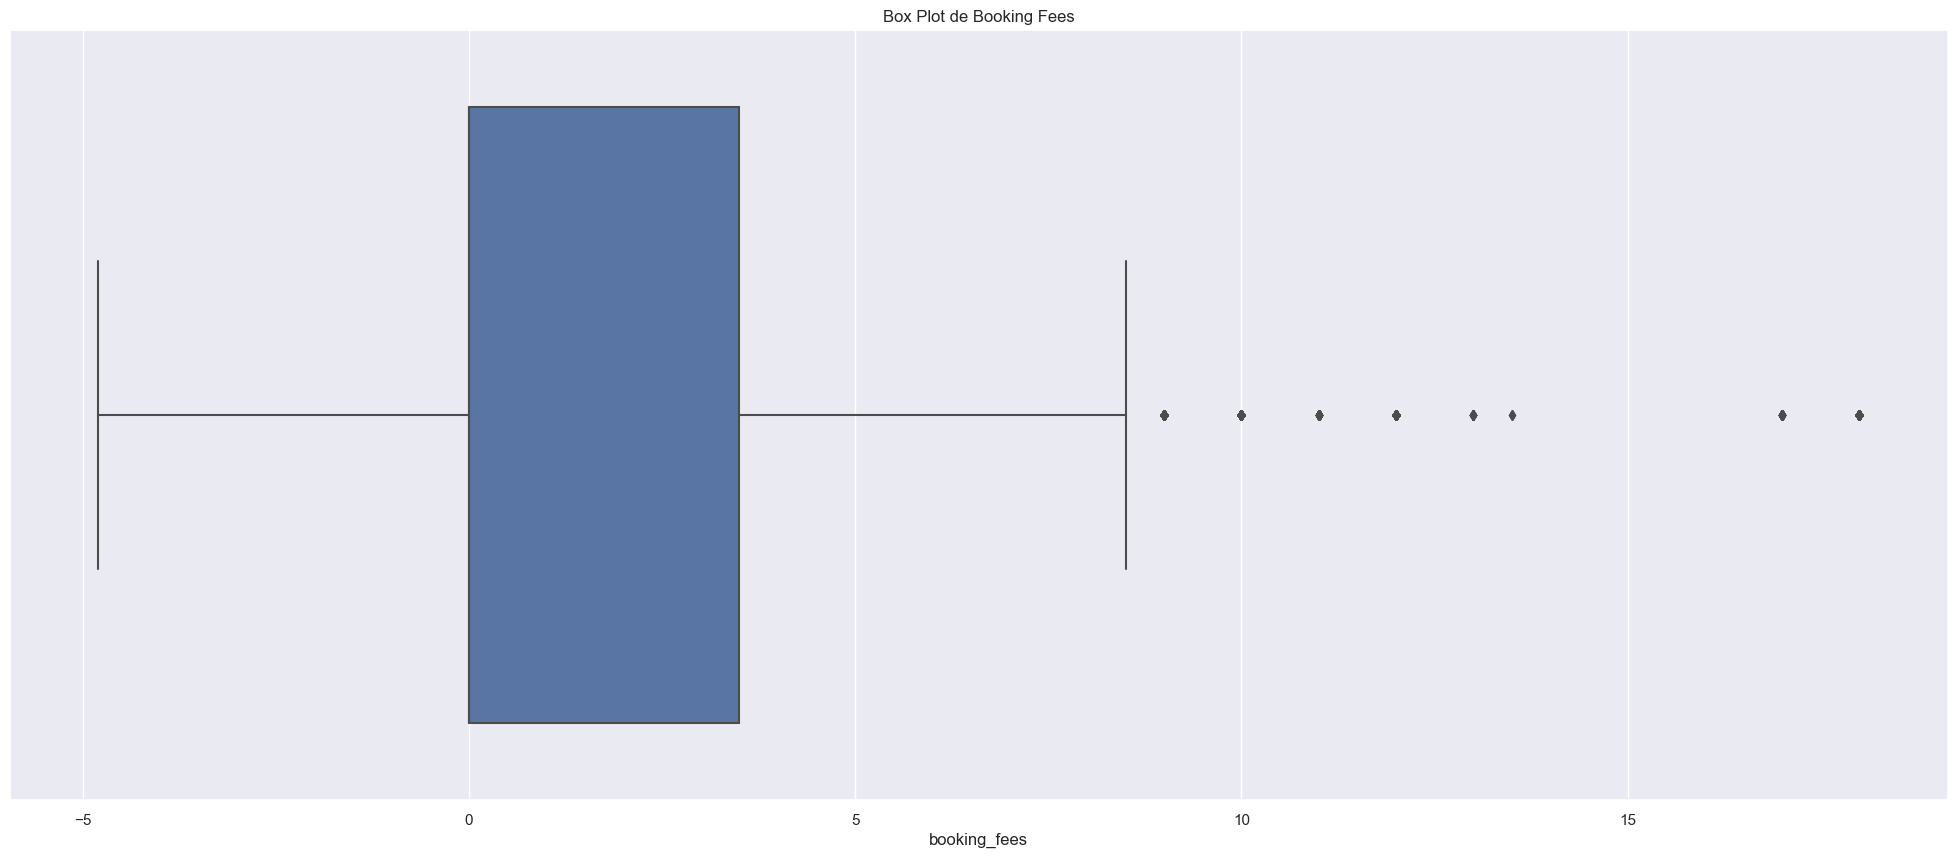

In [6]:
sns.boxplot(x=df['booking_fees'])
plt.title('Box Plot de Booking Fees')
plt.show()

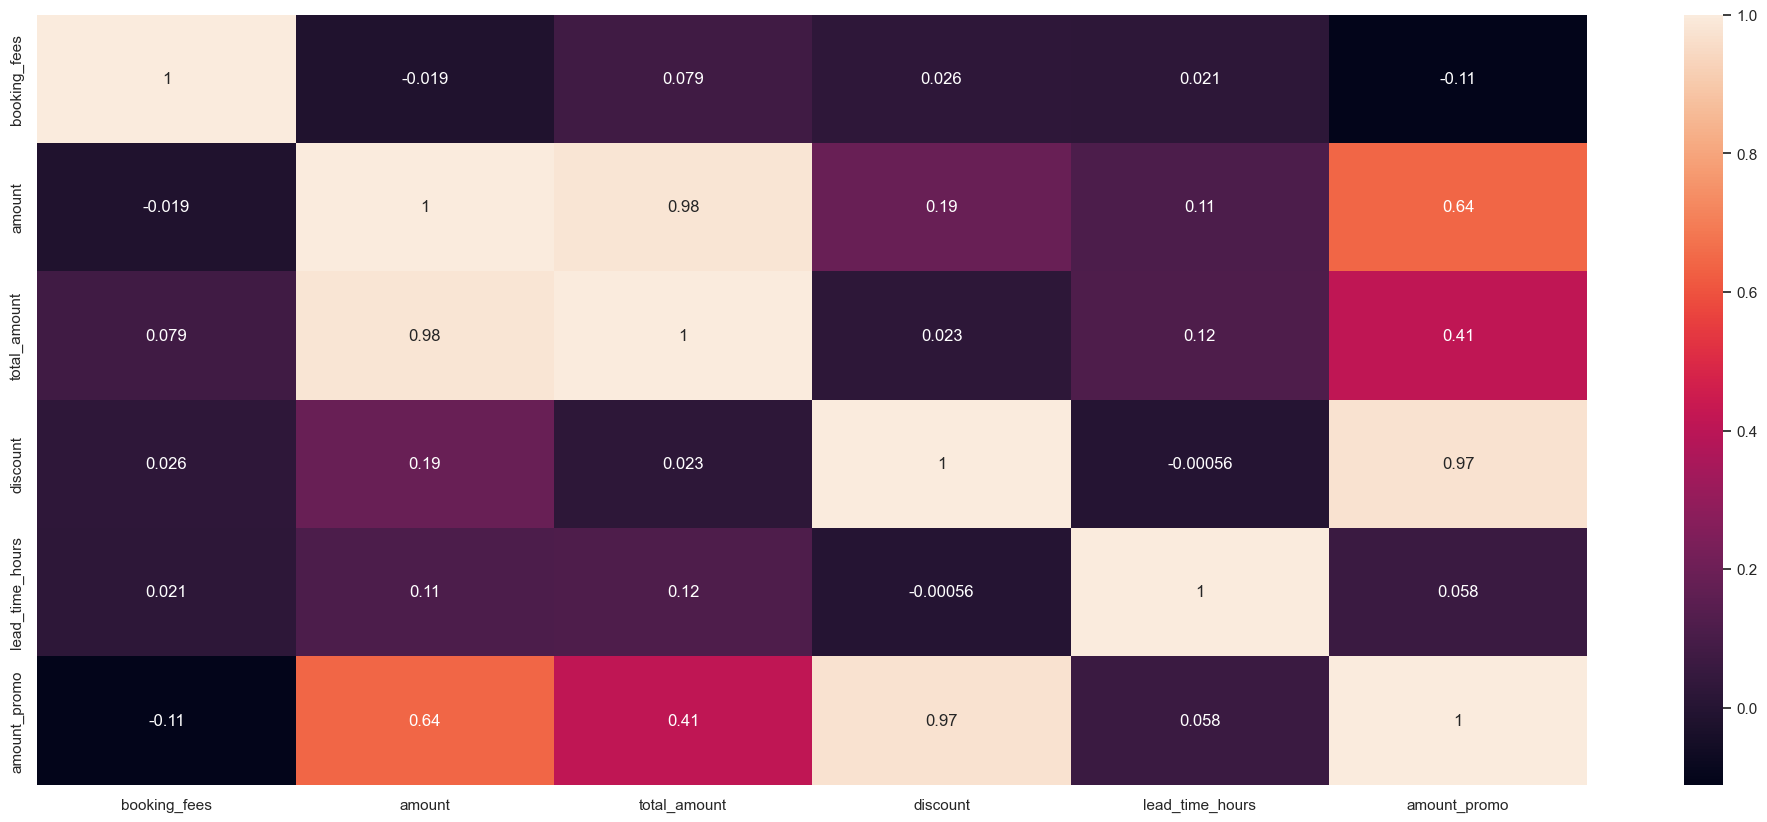

In [17]:
## NOT NEEDED RIGHT NOW, JUST EDA ##

# Filtrez le DataFrame pour ne garder que les colonnes numériques
numeric_cols = df.select_dtypes(include=[np.number])

# Calculez la matrice de corrélation
corr_matrix = numeric_cols.corr()

# Affichez la heatmap
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [4]:
## TEST FOR NEXT STEP ##
# This code prepares the data for a SARIMAX model by grouping 
# the data by date and calculating the total number of sales and statistics 
# for the exogenous variables. It also fills any missing values with 0 and 
# checks if the index is of type datetime. Finally, it sorts the data by date.

# Préparation des données pour le modèle SARIMAX
df['date'] = df['beginning_date_hour'].dt.date

# Regroupement par 'date' et calcul du nombre total de places vendues et des statistiques pour les variables exogènes
daily_data = df.groupby('date').agg({
    'id':'size', 
    'amount':'mean', 
    'amount_promo':'mean', 
    'booking_fees': 'mean',
    'discount': 'mean'}) 

daily_data.rename(columns={'id':'total_sales'}, inplace=True)

daily_data = daily_data.fillna(0) # cas de amount_promo

# Check if index est de type datetime
daily_data.index = pd.to_datetime(daily_data.index)

# Tri par date
daily_data.sort_index(inplace=True)

In [7]:
# La série temporelle
daily_data.index = pd.to_datetime(daily_data.index)

In [11]:
daily_data.drop

,total_sales,amount,amount_promo,booking_fees,discount
date,,,,,
2019-01-02,34.0,30.823529,5.67600,2.460294,0.834706
2019-01-03,53.0,31.569811,3.14500,3.089623,0.237358
2019-01-04,85.0,27.372941,5.97375,2.714353,1.124471
2019-01-05,50.0,31.762000,7.87200,2.449000,0.787200
2019-01-06,43.0,32.390698,4.78750,3.218605,0.445349
...,...,...,...,...,...
2023-12-30,NaN,NaN,NaN,NaN,NaN
2023-12-31,NaN,NaN,NaN,NaN,NaN
2024-01-01,NaN,NaN,NaN,NaN,NaN


In [10]:
# Définir la fréquence (ici quotidienne)
daily_data = daily_data.asfreq('D')
# Décomposition saisonnière pour déterminer la saisonnalité (si présente)
decomposition = sm.tsa.seasonal_decompose(daily_data, model='additive')
fig = decomposition.plot()
plt.show()

ValueError: This function does not handle missing values